In [1]:
%clear

In [2]:
import tensorflow as tf
import numpy as np
import argparse
import socket
import importlib
import time
import os
import matplotlib.pyplot as plt

import scipy.misc
import sys
BASE_DIR = os.getcwd()
ROOT_DIR = os.path.dirname(BASE_DIR) +'/pointnet2-master'
sys.path.append(BASE_DIR)
sys.path.append(ROOT_DIR)
print('BASE_DIR =' ,BASE_DIR)
print('ROOT_DIR =' ,ROOT_DIR)
sys.path.append(os.path.join(ROOT_DIR, 'models'))
sys.path.append(os.path.join(ROOT_DIR, 'utils'))
import provider
import modelnet_dataset
import modelnet_h5_dataset
import my_data_import as chao_data_import
import otherClassDataImport as chao_data_import_2

BASE_DIR = /home/chaotang/文档/Try
ROOT_DIR = /home/chaotang/文档/pointnet2-master


MODEL_PATH /home/chaotang/文档/pointnet2-master/log/model.ckpt
cur_batch_data (16, 2048, 3)
cur_batch_label (16,)
Original_pl (16, 2048, 3)


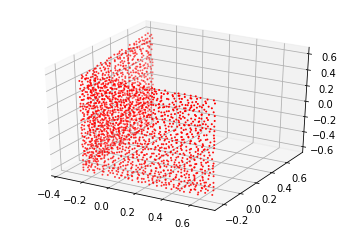

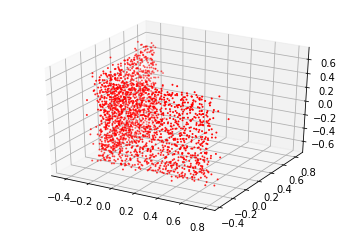

In [4]:
BATCH_SIZE = 16
NUM_POINT = 2048
MODEL_PATH = ROOT_DIR + '/log/model.ckpt'
print('MODEL_PATH',MODEL_PATH)
GPU_INDEX =0
MODEL = importlib.import_module('pointnet2_cls_ssg') # import network module

test_index = 9
# Make sure batch data is of same size
cur_batch_data = np.zeros((BATCH_SIZE,NUM_POINT,3))
cur_batch_label = np.zeros((BATCH_SIZE), dtype=np.int32)

Original_pl = np.zeros((BATCH_SIZE,NUM_POINT,3))
Noisy_pl = np.zeros((BATCH_SIZE,NUM_POINT,3))

cur_batch_data,cur_batch_label = chao_data_import_2.get_data()
print('cur_batch_data',cur_batch_data.shape)# The shape of the data set is (16, 2048, 3)
print('cur_batch_label',cur_batch_label.shape)

Original_pl[:] = cur_batch_data[:]# 干净的点云
Noisy_pl[:] = cur_batch_data[:]# 有噪音的点云
Original_label = np.zeros(cur_batch_label.shape)
Original_label[:] = cur_batch_label[:]
print('Original_pl',Original_pl.shape)
chao_data_import.draw_pointcloud(Original_pl[test_index])
########################只有前k个点加上了噪音##############################################
k = 1000
Noisy_pl[test_index,0:k,:] = Original_pl[test_index,0:k,:] + 0.05 * np.random.normal(size = (k,3))# Noisy的点云

chao_data_import.draw_pointcloud(Noisy_pl[test_index])

Instructions for updating:
Colocations handled automatically by placer.
(16, 2048, 3)
(16, 1000, 3)
(16, 1048, 3)

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/chaotang/文档/pointnet2-master/log/model.ckpt
Model restored!!!!!
Calculating...
Original_score  -12.455761
E1_val 9.188463
predval [ 25.924776 -56.97483  -27.615189 -38.156902 -52.26111  -78.226425
 -68.44486  -35.595825  -9.66452  -66.157936 -74.249626 -42.539658
 -46.20773  -54.19665  -61.27366  -46.298042 -61.643

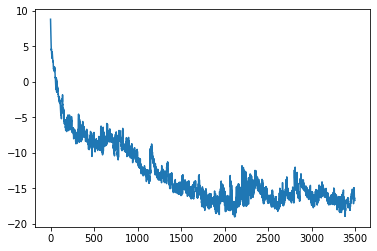

In [5]:
tf.reset_default_graph()
##############################
#### Redefine the Graph#######
##############################
num_votes = 1
is_training = False

is_training_pl = tf.placeholder(tf.bool, shape=())
# def placeholder_inputs(batch_size, num_point):
pointclouds_pl = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_POINT, 3)) # shape = (16,1024,3)
labels_pl = tf.placeholder(tf.int32, shape=(BATCH_SIZE))

# define delta P which can be optimized by tensorflow

# deltaP = tf.get_variable('deltaP',dtype=tf.float32,shape = pointclouds_pl.shape,initializer=tf.zeros_initializer)
deltaP = tf.get_variable('deltaP',dtype=tf.float32,shape = (BATCH_SIZE,k,3),initializer=tf.zeros_initializer)
#FixedP = tf.get_variable('deltaP',dtype=tf.float32,shape = (BATCH_SIZE,NUM_POINT-100,3),initializer=tf.zeros_initializer)
Part1 = pointclouds_pl[:,0:k,:] + deltaP
Part2 = pointclouds_pl[:,k:,:]
New_pcloud_pl = tf.concat([Part1,Part2],axis = 1)
print(New_pcloud_pl.shape)
print(Part1.shape)
print(Part2.shape)
#New_pcloud_pl =  deltaP

pred,end_points = MODEL.get_model(New_pcloud_pl, is_training_pl)

##########################################################
 # define enegy function
E1 = 10 * tf.reduce_sum(tf.square(deltaP[test_index]))
E2 = - pred[test_index,int(Original_label[test_index])]
E_total =  E1 + E2 # scalar tensor

    
# optimizer define
optimizer = tf.train.GradientDescentOptimizer(0.00005)
#optimizer = tf.contrib.opt.GGTOptimizer()
train_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope = 'deltaP:0')
train_op = optimizer.minimize(E_total,var_list = train_var)
    # feed director
######################################################################
pre_trained_list = []
var_list = []
for var in tf.global_variables():# 并不是model用的都是trainable的
    #print(var.name)
    var_list.append(var)
pre_trained_list = var_list[1:]
#for var in pre_trained_list:
    #print(var.name)
##################################
####### Graph has been redefine###
#################################
# 训练条件配置
saver = tf.train.Saver(var_list=pre_trained_list)

init = tf.global_variables_initializer()
# Create a session(如果没有下面这一串的sess指令，回复会出错)
with tf.device('/gpu:0'):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    config.log_device_placement = False
with tf.Session() as sess:
    sess.run(tf.variables_initializer([deltaP])) # BN层没有运用，但也需要初始化
    sess.run(init)

    saver.restore(sess,MODEL_PATH)
    print('Model restored!!!!!')
    print('Calculating...')
    '''
    strangeTensor = var_list[5].name
    graph = tf.get_default_graph()
    Tensor = graph.get_tensor_by_name(strangeTensor)
    print(strangeTensor)
    print(Tensor.eval())
    '''
    clean_feed = {pointclouds_pl:Original_pl,is_training_pl:is_training}
    _,original_Score = sess.run([train_op,E2],feed_dict = clean_feed)
    
    feed = {pointclouds_pl:Noisy_pl,is_training_pl:is_training}
    loss_mat = np.zeros((3500,))
    
    for i in range(3500):
        _,loss_in_loop,E1_val,E2_val,predval = sess.run([train_op,E_total,E1,E2,pred],feed_dict = feed)
        loss_mat[i] = loss_in_loop
        #print('E2_val',-E2_val)
    displacement = deltaP[test_index].eval()
    print('Original_score ',-original_Score)
    print('E1_val',E1_val)
    print('predval',predval[test_index])
    print('displacement',np.sum(np.square(displacement)))
plt.plot(loss_mat)
print(np.amin(loss_mat))   

0.9192624707033774


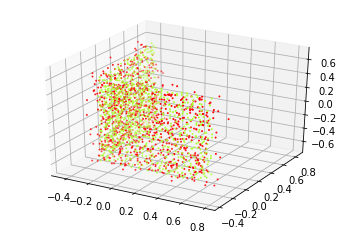

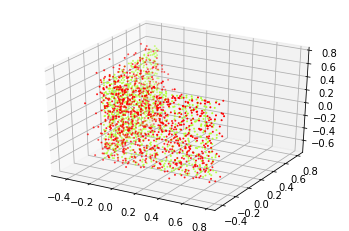

In [6]:
processed_displace = np.zeros((2048,3))
processed_displace[0:k] = displacement
New_pl = np.clip((processed_displace + Noisy_pl[test_index]),-1,1)

#chao_data_import.draw_pointcloud(Noisy_pl[test_index])
#chao_data_import.draw_pointcloud(New_pl)

plt.figure()
x,y,z = Noisy_pl[test_index][0:k,0],Noisy_pl[test_index][0:k,1],Noisy_pl[test_index][0:k,2]
x2,y2,z2 = Noisy_pl[test_index][k:,0],Noisy_pl[test_index][k:,1],Noisy_pl[test_index][k:,2]
ax = plt.subplot(111, projection='3d' )  # 创建一个三维的绘图工程
ax.scatter(x,y,z,c = 'r',s = 1)
ax.scatter(x2,y2,z2,c = 'greenyellow',s = 1)

plt.figure()
x,y,z = New_pl[0:k,0],New_pl[0:k,1],New_pl[0:k,2]
x2,y2,z2 = New_pl[k:,0],New_pl[k:,1],New_pl[k:,2]
ax = plt.subplot(111, projection='3d' )  # 创建一个三维的绘图工程
ax.scatter(x,y,z,c = 'r',s = 1)
ax.scatter(x2,y2,z2,c = 'greenyellow',s = 1)

difference = np.sum(np.square(New_pl - Noisy_pl[test_index]))
print(difference)

# Evaluation

In [7]:
import EvaluationFunction as Evaluate
chamfer_noisy  = 100 * Evaluate.chamfer_dist(Original_pl[test_index],Noisy_pl[test_index])
chamfer_new  = 100 * Evaluate.chamfer_dist(Original_pl[test_index],New_pl)
print('chamfer_noisy',chamfer_noisy)
print('chamfer_new',chamfer_new)

RMSD_noisy  = 100 * Evaluate.RMSD(Original_pl[test_index],Noisy_pl[test_index])
RMSD_new  = 100 * Evaluate.RMSD(Original_pl[test_index],New_pl)
print('RMSD_noisy',RMSD_noisy)
print('RMSD_new',RMSD_new)

chamfer_noisy 0.15347756430163337
chamfer_new 0.1827134181835124
RMSD_noisy 3.216340062800988
RMSD_new 3.643007660121607


In [8]:
import show3d_balls as show3dball

# 原样直接使用的pointnet++

In [9]:
show3dball.showpoints(Original_pl[test_index])

113

In [12]:
show3dball.showpoints(Noisy_pl[test_index])

113

In [13]:
show3dball.showpoints(New_pl)

113